In [2]:
import kan
import kan.utils as ku
import numpy as np
import torch.nn as nn
import torch
import qutip as qt
import matplotlib.pyplot as plt
import itertools
from libraries import utils
from libraries import magnetization
from libraries import j1j2_functions

In [3]:
N=12; J1=1
J2s = np.linspace(0, 0.5 - 0.5/100, 100)
print(J2s[-1])
gss = [qt.qload(f'../J1J2_info/N{N}/n{N}gs_J2_{round(J2, 3)}') for J2 in J2s]
states = utils.get_nonzero_states(N, gss[0], 1e-10)[0]
signs = [utils.get_nonzero_states(N, gs, 1e-10)[1] for gs in gss]

nd = 0b010101010101 # this never deviates, let this be of negative sign cos(pi/4 * amplitude)
index = states.index(nd)
print(nd)
for i in range(len(signs)):
    if signs[i][index] > 0:
        signs[i] = -1 * np.array(signs[i])
    else:
        signs[i] = np.array(signs[i])

devs = [(signs[0] != signs[i]).astype(float) for i in range(len(signs))]

def rfft(x):
    x = (-1) ** np.array(x)
    return np.fft.rfft(x)[1:]

input = utils.generate_input_samples(N, states)
print(input.shape)
ft_input = []
for x in input:
    amp_phase = []
    ft = rfft(x)
    for c in ft:
        amp_phase.append(np.abs(c))
        amp_phase.append(np.angle(c) % (2 * np.pi))
    ft_input.append(amp_phase)
ft_input = torch.tensor(ft_input)

0.495
1365
torch.Size([924, 12])


C:\Users\taoha\AppData\Local\Temp\ipykernel_38192\2901660590.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x = (-1) ** np.array(x)


In [4]:
for i in range(len(devs)):
    print(i, round(J2s[i], 3), sum(devs[i]))

0 0.0 0.0
1 0.005 0.0
2 0.01 0.0
3 0.015 0.0
4 0.02 0.0
5 0.025 0.0
6 0.03 0.0
7 0.035 0.0
8 0.04 0.0
9 0.045 0.0
10 0.05 0.0
11 0.055 0.0
12 0.06 0.0
13 0.065 0.0
14 0.07 0.0
15 0.075 0.0
16 0.08 0.0
17 0.085 0.0
18 0.09 0.0
19 0.095 0.0
20 0.1 0.0
21 0.105 0.0
22 0.11 0.0
23 0.115 0.0
24 0.12 0.0
25 0.125 12.0
26 0.13 12.0
27 0.135 12.0
28 0.14 12.0
29 0.145 12.0
30 0.15 12.0
31 0.155 12.0
32 0.16 12.0
33 0.165 12.0
34 0.17 36.0
35 0.175 36.0
36 0.18 36.0
37 0.185 84.0
38 0.19 108.0
39 0.195 108.0
40 0.2 108.0
41 0.205 108.0
42 0.21 96.0
43 0.215 96.0
44 0.22 96.0
45 0.225 96.0
46 0.23 96.0
47 0.235 96.0
48 0.24 120.0
49 0.245 120.0
50 0.25 120.0
51 0.255 120.0
52 0.26 144.0
53 0.265 144.0
54 0.27 144.0
55 0.275 144.0
56 0.28 144.0
57 0.285 144.0
58 0.29 192.0
59 0.295 192.0
60 0.3 192.0
61 0.305 192.0
62 0.31 240.0
63 0.315 240.0
64 0.32 264.0
65 0.325 264.0
66 0.33 264.0
67 0.335 264.0
68 0.34 240.0
69 0.345 264.0
70 0.35 264.0
71 0.355 312.0
72 0.36 336.0
73 0.365 336.0
74 0.37 33

In [6]:
sum(devs[25])

np.float64(12.0)

In [7]:
torch.manual_seed(2)
mlp = nn.Sequential(
    nn.Linear(N, 1),
    nn.Sigmoid(),
    #nn.Linear(3, 1),
    #nn.Sigmoid()
)
index = 70
opt = torch.optim.Adam(mlp.parameters(), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 50000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        loss = floss(mlp(ft_input), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(mlp(ft_input)), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))
# seems 1 hidden layer MLP can work for anything with very good loss (there may be too many parameters)
# up to index 71 dev string can be done with no hidden layers (linear separator) seems mostly just like based on lowest freq
# more requires more training epochs
# it seems like index >= 72 becomes more difficult??
# seems >=72 can easily be done with non-linear separator
# (N, 3, 1) is minimal for index 92

0.6927897334098816
0.010283734649419785
0.0017282887129113078
0.0005366969853639603
0.000205744756385684
5.128790144226514e-05
tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


In [8]:
[n for n in mlp.parameters()]

[Parameter containing:
 tensor([[ 7.7016e+01, -1.1658e-02,  8.5867e+01,  1.5922e-02, -1.2201e+01,
          -8.4497e-02,  2.0635e+00, -8.0911e-02, -3.5666e+00, -2.8490e-02,
          -3.3578e+01, -1.0719e-02]], requires_grad=True),
 Parameter containing:
 tensor([-561.0061], requires_grad=True)]

In [10]:
import kan

In [12]:
torch.manual_seed(2)
kan_model = kan.KAN(width=[N, 1])
kan_model(ft_input);
for i in range(0, N, 2):
    kan_model.fix_symbolic(0, i, 0, 'x', verbose=False, log_history=False)
    kan_model.fix_symbolic(0, i + 1, 0, '0', verbose=False, log_history=False)
index = 70
opt = torch.optim.LBFGS(kan_model.parameters(), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 100; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        loss = floss(torch.sigmoid(kan_model(ft_input)), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(torch.sigmoid(kan_model(ft_input))), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))
# okay this basically has same behavior as kan sort of makes sense

checkpoint directory created: ./model
saving model version 0.0
1.076793909072876
2.2413047418012866e-08
1.8615663677223893e-08
1.8615663677223893e-08
1.8615663677223893e-08
1.8615663677223893e-08
tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


In [13]:
print(floss(torch.round(torch.sigmoid(kan_model(ft_input))), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))

tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


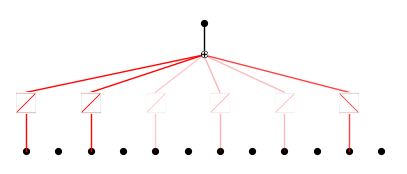

In [14]:
kan_model.plot()

In [15]:
ku.ex_round(kan_model.symbolic_formula()[0][0], 3)

148.634*x_1 - 41.268*x_11 + 150.147*x_3 + 12.925*x_5 + 17.412*x_7 + 18.797*x_9 - 1239.845

In [16]:
# we try taylor expansion include x^2 term here
quad_ft = torch.hstack((ft_input, ft_input ** 2))#, ft_input ** 3))
print(quad_ft.shape)

torch.manual_seed(2)
man_tensor = torch.tensor([[1196.2830, 0, -804.1158, 0, -223.7516, 0, -223.8448, 0, -398.4391, 0, 5.0210, 0,
          -213.9757, 0, 230.4781, 0,  44.6948, 0, 129.5988, 0, 137.5468, 0,  12.5491, 0,]], requires_grad=True)
          #   9.3357, 0, -19.6510, 0, -3.7282, 0, -17.5709, 0, -18.8858, 0, -5.8622, 0]],
        #requires_grad=True)
man_bias = torch.tensor([4.8512], requires_grad=True)
man_linear = nn.Linear(2*N, 1)
# man_linear.weight = nn.Parameter(man_tensor)
# man_linear.bias = nn.Parameter(man_bias)
quad_mlp = nn.Sequential(
    man_linear,
    nn.Sigmoid(),
)
index = 72
opt = torch.optim.LBFGS(quad_mlp.parameters(), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 50000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        loss = floss(quad_mlp(quad_ft), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(quad_mlp(quad_ft)), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))
# this seems to work until index 83 (with manual seed 2)
# with >=84 it seems to get stuck at 0.258 loss, tried seed up to 5 
# simply trying cubic parameters without the cubic parts also doesn't work 
# even though the cubic factors are sort of small, assuming that the inputs are large since cubes
""" params from cubic amp training
[Parameter containing:
 tensor([[1196.2830, -804.1158, -223.7516, -223.8448, -398.4391,    5.0210,
          -213.9757,  230.4781,   44.6948,  129.5988,  137.5468,   12.5491,
             9.3357,  -19.6510,   -3.7282,  -17.5709,  -18.8858,   -5.8622]],
        requires_grad=True),
 Parameter containing:
 tensor([4.8512], requires_grad=True)]
 """

torch.Size([924, 24])
1.8167599439620972
6.525795726020078e-08
6.525795726020078e-08
6.525795726020078e-08
6.525795726020078e-08
6.525795726020078e-08
tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


' params from cubic amp training\n[Parameter containing:\n tensor([[1196.2830, -804.1158, -223.7516, -223.8448, -398.4391,    5.0210,\n          -213.9757,  230.4781,   44.6948,  129.5988,  137.5468,   12.5491,\n             9.3357,  -19.6510,   -3.7282,  -17.5709,  -18.8858,   -5.8622]],\n        requires_grad=True),\n Parameter containing:\n tensor([4.8512], requires_grad=True)]\n '

In [17]:
[n for n in quad_mlp.parameters()]

[Parameter containing:
 tensor([[ 1.4656e+02,  1.2702e+00,  6.8296e+01,  1.1211e+00,  1.2955e+01,
           3.9920e-01,  2.7553e+01,  4.0684e+00,  6.0542e+00,  2.3855e+00,
           2.7811e+01, -1.6409e-02, -2.1145e+01, -1.4093e-01, -1.2998e+01,
          -1.3497e-01, -8.4991e+00, -5.9915e-02, -1.1685e+01, -6.5229e-01,
          -8.9387e+00, -3.9143e-01, -1.2097e+01,  5.0671e-02]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.9789], requires_grad=True)]

In [18]:
x = nn.Linear(3, 1)
print(x.weight, x.bias)
x.weight = nn.Parameter(torch.tensor([[1.0, 2.0, 3.0]]))
x.bias = nn.Parameter(torch.tensor([-1.0]))
print(x.weight, x.bias)

Parameter containing:
tensor([[ 0.1520, -0.0277, -0.3233]], requires_grad=True) Parameter containing:
tensor([-0.3272], requires_grad=True)
Parameter containing:
tensor([[1., 2., 3.]], requires_grad=True) Parameter containing:
tensor([-1.], requires_grad=True)


In [19]:
[n for n in quad_mlp.parameters()]

[Parameter containing:
 tensor([[ 1.4656e+02,  1.2702e+00,  6.8296e+01,  1.1211e+00,  1.2955e+01,
           3.9920e-01,  2.7553e+01,  4.0684e+00,  6.0542e+00,  2.3855e+00,
           2.7811e+01, -1.6409e-02, -2.1145e+01, -1.4093e-01, -1.2998e+01,
          -1.3497e-01, -8.4991e+00, -5.9915e-02, -1.1685e+01, -6.5229e-01,
          -8.9387e+00, -3.9143e-01, -1.2097e+01,  5.0671e-02]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.9789], requires_grad=True)]

In [20]:
# we try taylor expansion include x^3 term here
cub_ft = torch.hstack((ft_input, ft_input ** 2, ft_input ** 3))
print(cub_ft.shape)

# it seems manual seed 2 is much better than man seed 1??
torch.manual_seed(2)
cub_mlp = nn.Sequential(
    nn.Linear(3*N, 1),
    nn.Sigmoid(),
)
index = 84
opt = torch.optim.LBFGS(cub_mlp.parameters(), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 50000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        loss = floss(cub_mlp(cub_ft), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(cub_mlp(cub_ft)), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))
# for some reason it seems like this struggles with man seed 1 but not 2??

torch.Size([924, 36])
7.259513854980469
1.74056165036518e-08
1.74056165036518e-08
1.74056165036518e-08
1.74056165036518e-08
1.74056165036518e-08
tensor(0., grad_fn=<BinaryCrossEntropyBackward0>)


In [21]:
[n for n in cub_mlp.parameters()]

[Parameter containing:
 tensor([[ 5.5488e+03,  1.3914e+02, -3.8474e+03, -1.3676e-01, -1.1280e+03,
           6.9028e+01, -9.3511e+02, -4.2222e+01, -1.8845e+03,  1.0042e+02,
          -5.2761e+00,  7.5677e-03, -9.6418e+02, -5.3038e+01,  1.0876e+03,
          -4.5746e+00,  2.0668e+02, -2.0874e+01,  5.7649e+02,  2.0002e+01,
           6.1209e+02, -3.7364e+01, -1.3282e+01,  9.4748e-02,  3.9969e+01,
           5.4173e+00, -9.1240e+01,  7.7370e-01, -1.4579e+01,  1.9856e+00,
          -7.9998e+01, -2.4192e+00, -8.3323e+01,  3.7031e+00, -6.4266e+00,
          -1.5480e-01]], requires_grad=True),
 Parameter containing:
 tensor([21.0776], requires_grad=True)]

In [22]:
ft_input[:, ::2] # amplitudes only

tensor([[7.7274e+00, 4.5776e-16, 2.8284e+00, 1.1102e-16, 2.0706e+00, 0.0000e+00],
        [6.6921e+00, 2.0000e+00, 0.0000e+00, 3.4641e+00, 1.7932e+00, 4.0000e+00],
        [5.8186e+00, 3.4641e+00, 2.8284e+00, 3.4641e+00, 2.4786e+00, 0.0000e+00],
        ...,
        [5.8186e+00, 3.4641e+00, 2.8284e+00, 3.4641e+00, 2.4786e+00, 0.0000e+00],
        [6.6921e+00, 2.0000e+00, 0.0000e+00, 3.4641e+00, 1.7932e+00, 4.0000e+00],
        [7.7274e+00, 4.5776e-16, 2.8284e+00, 1.1102e-16, 2.0706e+00, 0.0000e+00]])

In [23]:
# we try taylor expansion include x^3 term here with only amplitudes
amp_input = ft_input[:, ::2]

cub_amp = torch.hstack((amp_input, amp_input ** 2, amp_input ** 3))
print(cub_amp.shape)

torch.manual_seed(1)
cub_amp_mlp= nn.Sequential(
    nn.Linear(3*N // 2, 1),
    nn.Sigmoid(),
)
index = 84
opt = torch.optim.LBFGS(cub_amp_mlp.parameters(), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 50000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        loss = floss(cub_amp_mlp(cub_amp), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(cub_amp_mlp(cub_amp)), torch.tensor(devs[index], dtype=torch.float32).reshape(-1, 1)))
# basically we gotta play around with man seed (1 default)
# fails ind=72, passes 80, 83, 84, seems like most else
# man seed 2 works for ind=72

torch.Size([924, 18])
8.566025733947754
1.4223613398200996e-08
1.4223613398200996e-08


KeyboardInterrupt: 

In [24]:
[n for n in cub_amp_mlp.parameters()]

[Parameter containing:
 tensor([[1196.2830, -804.1158, -223.7516, -223.8448, -398.4391,    5.0210,
          -213.9757,  230.4781,   44.6948,  129.5988,  137.5468,   12.5491,
             9.3357,  -19.6510,   -3.7282,  -17.5709,  -18.8858,   -5.8622]],
        requires_grad=True),
 Parameter containing:
 tensor([4.8512], requires_grad=True)]

In [25]:
cub_amp.shape

torch.Size([924, 18])

In [26]:
torch.vstack((1, 1))

TypeError: expected Tensor as element 0 in argument 0, but got int

In [27]:
# we try taylor expansion include x^3 term here with only amplitudes and also J2 term

cub_amp_j2 = torch.vstack((cub_amp,) * len(J2s))
j2_data = torch.vstack(tuple(torch.tensor([j2] * cub_amp.shape[0], dtype=torch.float32).reshape(-1, 1) for j2 in J2s))
j2_signs = torch.vstack(tuple(torch.tensor(devs[i], dtype=torch.float32).reshape(-1, 1) for i in range(len(devs))))
print(cub_amp_j2.shape, j2_data.shape, j2_signs.shape)
print(cub_amp_j2.dtype, j2_data.dtype, j2_signs.dtype)

torch.Size([92400, 18]) torch.Size([92400, 1]) torch.Size([92400, 1])
torch.float32 torch.float32 torch.float32


In [28]:
# we try taylor expansion include x^3 term here with only amplitudes and also J2 term

torch.manual_seed(5)
amp_cub = nn.Sequential(
    nn.Linear(3*N // 2, 1),
)

j2_lin = nn.Sequential(
    nn.Linear(1, 1),
)

opt = torch.optim.LBFGS(itertools.chain(amp_cub.parameters(), j2_lin.parameters()), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 1000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(amp_cub(cub_amp_j2) * j2_lin(j2_data))
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(torch.sigmoid(amp_cub(cub_amp_j2) * j2_lin(j2_data))), j2_signs))
# 0.2232, 0.2527, 0.2276, 0.2274, 0.2232, 84.169 local min for seeds 0-5

40.055763244628906
84.16883087158203
84.16883087158203
84.16883087158203
84.16883087158203
84.16883087158203
tensor(84.1688, grad_fn=<BinaryCrossEntropyBackward0>)


In [29]:
# try including J2^2 

j2_data_quad = torch.hstack((j2_data, j2_data ** 2))

torch.manual_seed(5)
amp_cub = nn.Sequential(
    nn.Linear(3*N // 2, 1),
)

j2_quad = nn.Sequential(
    nn.Linear(2, 1),
)

opt = torch.optim.LBFGS(itertools.chain(amp_cub.parameters(), j2_quad.parameters()), lr=0.1)
floss = torch.nn.BCELoss()
epochs = 1000; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(amp_cub(cub_amp_j2) * j2_quad(j2_data_quad))
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(floss(torch.round(torch.sigmoid(amp_cub(cub_amp_j2) * j2_quad(j2_data_quad))), j2_signs))
# most losses around 0.1903 and 0.1905 for various seeds

1.421175479888916
0.19052742421627045
0.19052742421627045
0.19052742421627045
0.19052742421627045
0.19052742421627045
tensor(15.8312, grad_fn=<BinaryCrossEntropyBackward0>)


In [30]:
# try including J2^3

j2_data_cub = torch.hstack((j2_data, j2_data ** 2, j2_data ** 3))

torch.manual_seed(2)
amp_cub = nn.Sequential(
    nn.Linear(3*N // 2, 1),
)

j2_cub = nn.Sequential(
    nn.Linear(3, 1),
    nn.Sigmoid(),
)

opt = torch.optim.LBFGS(itertools.chain(amp_cub.parameters(), j2_cub.parameters()), lr=0.05)
floss = torch.nn.BCELoss()
epochs = 200; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(amp_cub(cub_amp_j2) * j2_cub(j2_data_cub))
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(amp_cub(cub_amp_j2) * j2_cub(j2_data_cub))), j2_signs))
#

12.303403854370117
0.21287591755390167
0.21181952953338623
0.21181946992874146
0.21181945502758026
0.21181945502758026
tensor(0.1583, grad_fn=<MseLossBackward0>)


In [31]:
j2_data.shape

torch.Size([92400, 1])

In [ ]:
# try form f(x) * (a*J2 + b*J2^3 + c*J2^3 + d)

j2_data_cub = torch.hstack((torch.ones(j2_data.shape), j2_data, j2_data ** 2, j2_data ** 3))

torch.manual_seed(0)
amp_cub = nn.Sequential(
    nn.Linear(3*N // 2, 1),
)

j2_cub = nn.Sequential(
    nn.Linear(4, 1),
    nn.Sigmoid(),
)

opt = torch.optim.LBFGS(itertools.chain(amp_cub.parameters(), j2_cub.parameters()), lr=0.05)
floss = torch.nn.BCELoss()
epochs = 200; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(amp_cub(cub_amp_j2) * j2_cub(j2_data_cub))
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(amp_cub(cub_amp_j2) * j2_cub(j2_data_cub))), j2_signs))
# seeds 0-2 go to 0.693, 0.209, 15., 

15.443916320800781
0.21227507293224335
0.21161410212516785
0.6931473612785339
0.6931473612785339
0.6931473612785339
tensor(0.1782, grad_fn=<MseLossBackward0>)


In [40]:
cub_amp.shape

torch.Size([924, 18])

In [45]:
cub_amp[:, 0].round(decimals=5).unique()

tensor([0.0000, 1.0353, 1.4641, 1.7931, 2.0000, 2.0705, 2.4786, 2.8284, 3.0119,
        3.4641, 3.8637, 4.0000, 4.4721, 4.7883, 4.8990, 5.4641, 5.6568, 5.8186,
        6.6921, 7.7274])

In [46]:
prod = 1
for i in range(6):
    prod *= len(cub_amp[:, i].round(decimals=5).unique())
print(prod)

307200


In [49]:
cub_amp_j2.shape

torch.Size([92400, 18])

In [50]:
j2_data

tensor([[0.0000],
        [0.0000],
        [0.0000],
        ...,
        [0.4950],
        [0.4950],
        [0.4950]])

In [65]:
# try form f(x) + g(x) * J2?? where f, g are functions of up to amp^3

torch.manual_seed(3)
f = nn.Sequential(nn.Linear(3 * N // 2, 1))
g = nn.Sequential(nn.Linear(3 * N // 2, 1))

opt = torch.optim.LBFGS(itertools.chain(f.parameters(), g.parameters()), lr=0.05)
floss = torch.nn.BCELoss()
epochs = 200; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data)
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data)), j2_signs))
# MAN SEED ONE LOOKS REALLY GOOD 0.077 loss, 0.0530 after rounding
# seed 3 also works.

14.007755279541016
0.1328033059835434
0.07802457362413406
0.0769345834851265
0.0769185945391655
0.07690788060426712
tensor(0.0525, grad_fn=<MseLossBackward0>)


In [57]:
0.05298701301217079 * 92400

4896.000002324581

In [56]:
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data)), j2_signs).item())

0.05298701301217079


In [58]:
[n for n in f.parameters()]

[Parameter containing:
 tensor([[ 9.4554e+02,  1.2648e+02, -6.5107e+01, -1.0524e+02, -4.0350e+02,
           1.2067e+00, -1.8690e+02, -2.6945e+01, -1.2389e+01, -9.2918e+00,
           1.9372e+02,  2.5092e+00,  9.6785e+00, -2.3714e+00, -2.0847e+00,
          -9.3538e-02, -3.1342e+01, -4.1929e+00]], requires_grad=True),
 Parameter containing:
 tensor([-0.3658], requires_grad=True)]

In [ ]:
[n for n in g.parameters()] 

[Parameter containing:
 tensor([[ 4.3857e+02, -7.4293e+01, -1.1010e+01, -2.0925e+00, -2.5207e+02,
           4.3039e-01, -9.7949e+01, -8.5202e+01,  4.1604e+01,  9.5317e+01,
          -9.0487e+01,  1.3474e+00,  6.1349e+00,  1.7650e+01, -1.1079e+00,
          -1.4105e+01,  3.0260e+01, -6.4721e-01]], requires_grad=True),
 Parameter containing:
 tensor([-1.9672], requires_grad=True)]

In [ ]:
# try form f(x) + g(x) * J2 + h(x) * J2^2 where f, g, h are functions of up to amp^3

torch.manual_seed(1)
f = nn.Sequential(nn.Linear(3 * N // 2, 1))
g = nn.Sequential(nn.Linear(3 * N // 2, 1))
h = nn.Sequential(nn.Linear(3 * N // 2, 1))

opt = torch.optim.LBFGS(itertools.chain(f.parameters(), g.parameters(), h.parameters()), lr=0.05)
floss = torch.nn.BCELoss()
epochs = 200; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data + h(cub_amp_j2) * j2_data ** 2)
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data + h(cub_amp_j2) * j2_data ** 2)), j2_signs))
# seed 0 gets to 0.0087 at some point but then goes to 12?
# seed 1 gets to 0.0076, 0.0026 after rounding --> 240 mistakes

15.92538833618164
0.06094572693109512
0.02474370039999485
0.008290494792163372
0.007655133493244648
0.007642410695552826
tensor(0.0026, grad_fn=<MseLossBackward0>)


In [73]:
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data + h(cub_amp_j2) * j2_data ** 2)), j2_signs).item())

0.002597402548417449


In [74]:
0.002597402548417449 * 92400

239.9999954737723

In [ ]:
# try form f(x) + g(x) * J2 + h(x) * J2^2 + p(x) * J2^3 where f, g, h, p are poly of up to amp^3

torch.manual_seed(0)
f = nn.Sequential(nn.Linear(3 * N // 2, 1))
g = nn.Sequential(nn.Linear(3 * N // 2, 1))
h = nn.Sequential(nn.Linear(3 * N // 2, 1))
p = nn.Sequential(nn.Linear(3 * N // 2, 1))
opt = torch.optim.LBFGS(itertools.chain(f.parameters(), g.parameters(), h.parameters(), p.parameters()), lr=0.05)
floss = torch.nn.BCELoss()
epochs = 200; datarate = epochs // 5
for i in range(epochs):
    def closure():
        opt.zero_grad()
        pred = torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data + h(cub_amp_j2) * j2_data ** 2 + p(cub_amp_j2 * j2_data ** 3))
        loss = floss(pred, j2_signs)
        loss.backward()
        return loss
    loss = opt.step(closure)
    if i % datarate == 0:
        print(loss.item())
print(loss.item())
print('rounded loss')
print(torch.nn.MSELoss()(torch.round(torch.sigmoid(f(cub_amp_j2) + g(cub_amp_j2) * j2_data + h(cub_amp_j2) * j2_data ** 2 + p(cub_amp_j2 * j2_data ** 3))), j2_signs).item())
# seed 0 makes no mistakes
# --> 76 parameter summarization of 92400 data points

14.77404499053955
0.06770095974206924
0.01351476926356554
4.1072066636616e-08
2.6715666123777737e-08
2.0031466263503717e-08
rounded loss
0.0


In [77]:
for part in [f, g, h, p]:
    print([n for n in part.parameters()])

[Parameter containing:
tensor([[ 8.1331e+04,  2.2957e+03, -6.2607e+03, -1.1200e+04, -5.0462e+04,
          9.2759e+02, -8.6915e+03, -1.2002e+02, -1.6636e+03,  4.5797e+02,
          1.1491e+04,  2.5280e+03, -8.1008e+01, -1.4897e+03, -6.5714e+01,
         -9.3733e+02, -1.4635e+03, -1.7452e+03]], requires_grad=True), Parameter containing:
tensor([35.6799], requires_grad=True)]
[Parameter containing:
tensor([[ 34290.3125,  -7816.3193,   -679.1583,   -123.8333, -18169.7969,
            303.3008, -17494.8066,  -4301.6851,   4433.3296,  11624.6035,
          16429.1602,   1185.9393,   2524.9736,   8240.8779,    -75.0549,
           3715.2371,   -685.3488,   4520.1831]], requires_grad=True), Parameter containing:
tensor([157.4534], requires_grad=True)]
[Parameter containing:
tensor([[ 13510.0361,  -6888.7915,    292.3169,  -3520.8335,  -7518.8770,
           -527.6835, -16550.3047,  -4387.2417,   3514.6880,  -3768.8623,
           9109.3232,  -2145.2217,  -2453.3430, -13142.0615,  -1477.1410,
